In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve, classification_report
import matplotlib.pyplot as plt

In [2]:
#cd /kaggle/input/flight-delay-and-causes/Flight_delay.csv

In [3]:
df=pd.read_csv("/kaggle/input/flight-delay-and-causes/Flight_delay.csv")

In [4]:
df.head()
df.describe()
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 484551 entries, 0 to 484550
Data columns (total 29 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DayOfWeek          484551 non-null  int64 
 1   Date               484551 non-null  object
 2   DepTime            484551 non-null  int64 
 3   ArrTime            484551 non-null  int64 
 4   CRSArrTime         484551 non-null  int64 
 5   UniqueCarrier      484551 non-null  object
 6   Airline            484551 non-null  object
 7   FlightNum          484551 non-null  int64 
 8   TailNum            484551 non-null  object
 9   ActualElapsedTime  484551 non-null  int64 
 10  CRSElapsedTime     484551 non-null  int64 
 11  AirTime            484551 non-null  int64 
 12  ArrDelay           484551 non-null  int64 
 13  DepDelay           484551 non-null  int64 
 14  Origin             484551 non-null  object
 15  Org_Airport        483374 non-null  object
 16  Dest               4

DayOfWeek               0
Date                    0
DepTime                 0
ArrTime                 0
CRSArrTime              0
UniqueCarrier           0
Airline                 0
FlightNum               0
TailNum                 0
ActualElapsedTime       0
CRSElapsedTime          0
AirTime                 0
ArrDelay                0
DepDelay                0
Origin                  0
Org_Airport          1177
Dest                    0
Dest_Airport         1479
Distance                0
TaxiIn                  0
TaxiOut                 0
Cancelled               0
CancellationCode        0
Diverted                0
CarrierDelay            0
WeatherDelay            0
NASDelay                0
SecurityDelay           0
LateAircraftDelay       0
dtype: int64

In [5]:
df = df[['DayOfWeek','Date','DepTime','Airline','Origin','Dest','CarrierDelay']]
df

,DayOfWeek,Date,DepTime,Airline,Origin,Dest,CarrierDelay
0,4,03-01-2019,1829,Southwest Airlines Co.,IND,BWI,2
1,4,03-01-2019,1937,Southwest Airlines Co.,IND,LAS,10
2,4,03-01-2019,1644,Southwest Airlines Co.,IND,MCO,8
3,4,03-01-2019,1452,Southwest Airlines Co.,IND,PHX,3
4,4,03-01-2019,1323,Southwest Airlines Co.,IND,TPA,0
...,...,...,...,...,...,...,...
484546,5,13-06-2019,1609,American Airlines Inc.,DFW,MCO,27
484547,6,14-06-2019,1616,American Airlines Inc.,DFW,MCO,11
484548,2,17-06-2019,1617,American Airlines Inc.,DFW,MCO,0
484549,7,22-06-2019,1607,American Airlines Inc.,DFW,MCO,1


In [6]:
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)

In [7]:
df['month'] = df['Date'].dt.month
df['day'] = df['Date'].dt.day

In [8]:
df = df.drop(columns=['Date'])

In [9]:
categories = df.select_dtypes(include=['object']).columns
categories

Index(['Airline', 'Origin', 'Dest'], dtype='object')

In [10]:
df_encoded = pd.get_dummies(df, drop_first=True)

In [11]:
df_encoded['is_delayed_60+'] = np.where(df_encoded['CarrierDelay'] > 60, 1, 0)

In [12]:
X = df_encoded.drop(columns=['is_delayed_60+', 'CarrierDelay'])
y = df_encoded['is_delayed_60+']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [14]:
train_set = pd.concat([X_train, y_train], axis= 1)

In [15]:
categories

Index(['Airline', 'Origin', 'Dest'], dtype='object')

In [16]:
for category in categories:
    one_hot_columns = [col for col in train_set.columns if col.startswith(f'{category}_')]
    if not one_hot_columns:
        continue
    train_set[category] = train_set[one_hot_columns].idxmax(axis=1)
    train_set = train_set.drop(columns=one_hot_columns)
    train_set[category] = train_set[category].str.replace(f'{category}_', '')

In [17]:
train_set

,DayOfWeek,DepTime,month,day,is_delayed_60+,Airline,Origin,Dest
132504,5,2124,2,22,0,US Airways Inc.,PHX,LAS
483050,4,2218,6,19,0,American Airlines Inc.,DFW,OAK
318401,6,1500,4,26,1,American Airlines Inc.,ORD,MIA
259287,3,2112,3,12,1,American Airlines Inc.,JNU,SEA
77835,6,1730,1,26,0,American Airlines Inc.,SJU,ORD
...,...,...,...,...,...,...,...,...
439107,4,1707,6,19,0,United Air Lines Inc.,PIT,ORD
117952,3,1752,2,27,0,Skywest Airlines Inc.,ORD,LAN
435829,2,1826,6,24,0,United Air Lines Inc.,LAX,ORD
305711,1,1350,4,21,0,Atlantic Southeast Airlines,SAT,ATL


In [18]:
train_set['is_delayed_60+'].value_counts()

is_delayed_60+
0    313876
1     25309
Name: count, dtype: int64

In [19]:
train_set['is_delayed_60+'].mean()

0.07461709686454294

In [20]:
train_set.groupby('Airline')['is_delayed_60+'].mean().sort_values(ascending=False).round(3)*100

Airline
Atlantic Southeast Airlines     16.3
Hawaiian Airlines Inc.          14.2
Skywest Airlines Inc.           10.3
American Airlines Inc.           9.0
Delta Air Lines Inc.             8.4
US Airways Inc.                  7.6
United Air Lines Inc.            7.5
American Eagle Airlines Inc.     7.0
JetBlue Airways                  5.9
Frontier Airlines Inc.           4.7
Southwest Airlines Co.           3.3
Name: is_delayed_60+, dtype: float64

In [21]:
DayOfWeek_pct_delayed = train_set.groupby('DayOfWeek')['is_delayed_60+'].mean().round(3)*100
DayOfWeek_pct_delayed

DayOfWeek
1    7.6
2    7.1
3    7.6
4    6.9
5    6.8
6    9.0
7    7.9
Name: is_delayed_60+, dtype: float64

In [22]:
pct_delay_by_origin = train_set.groupby('Origin')['is_delayed_60+'].mean().sort_values(ascending=False).round(3)*100
pct_delay_by_origin.head(20)

Origin
LWB    40.0
ACY    40.0
MQT    33.8
MCN    27.8
SLE    26.7
SCE    25.0
PFN    23.6
PHF    23.1
MKG    22.6
TRI    22.5
MEI    22.2
HHH    21.8
OAJ    21.5
FAY    21.4
ROW    21.4
VLD    20.3
AVL    19.8
ABI    19.4
EWN    19.3
CMI    18.4
Name: is_delayed_60+, dtype: float64

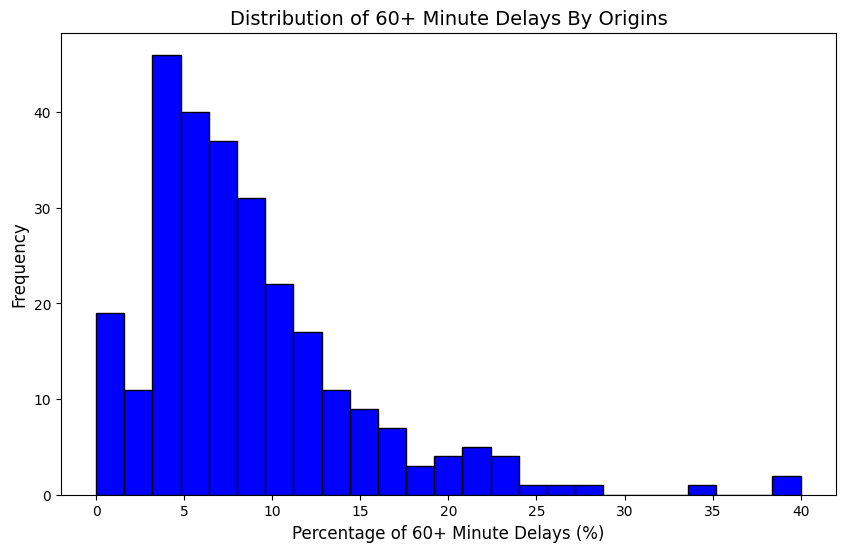

In [23]:
# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(pct_delay_by_origin.values, bins=25, color='blue', edgecolor='black')

# Add labels and title
plt.title("Distribution of 60+ Minute Delays By Origins", fontsize=14)
plt.xlabel("Percentage of 60+ Minute Delays (%)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)

# Show the plot
plt.show()

In [24]:
xgb_model = xgb.XGBClassifier(random_state=0, 
                              eval_metric='logloss')

In [25]:
xgb_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=0, ...)

In [26]:
# Train the model
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=0, ...)

In [27]:
y_pred = xgb_model.predict(X_test)

In [28]:
print(f"Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}")
print(f"Precision: {precision_score(y_test, y_pred) * 100:.2f}")
print(f"Recall: {recall_score(y_test, y_pred) * 100:.2f}")
print(f"F1: {f1_score(y_test, y_pred) * 100:.2f}")

Accuracy: 92.46
Precision: 58.50
Recall: 0.78
F1: 1.55


In [29]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[134322,     61],
       [ 10897,     86]])

In [30]:
# Predict probabilities for the test set (to calculate AUC)
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]  # We need probabilities for the positive class

# Calculate the AUC score
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"AUC Score: {auc_score:.4f}")

AUC Score: 0.7095


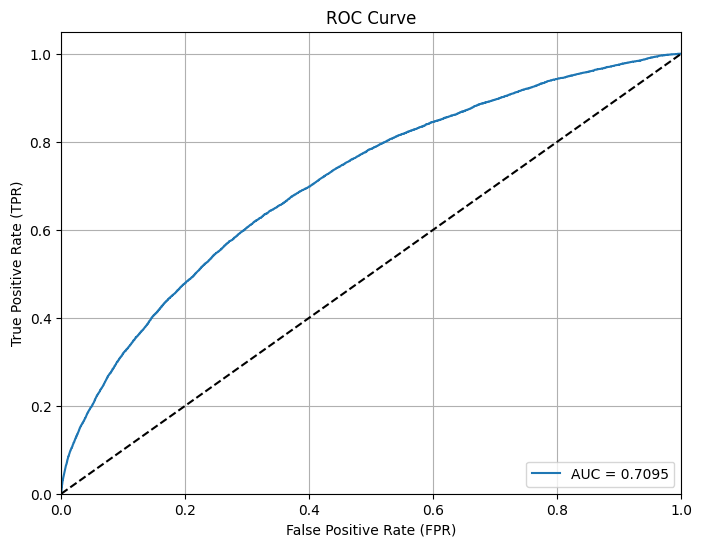

In [31]:
# Plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.4f}')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guessing
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()